In [1]:
 # This is boilerplate code to correctly setup the settings to for notebook.
import os, sys
for root, dirs, files in os.walk(os.getcwd()):
    print(root)
    if "pi0-analysis" in root.split("/"):
        pypath = root.split("pi0-analysis")[0] + "/pi0-analysis/analysis"
        print(pypath)
        break

sys.path.insert(0, pypath)

from python.analysis.NotebookUtils import init_notebook
%init_notebook

/home/pemb6649/pi0-analysis/analysis/sandbox
/home/pemb6649//pi0-analysis/analysis
/home/pemb6649//pi0-analysis/analysis
env: PYTHONPATH=/home/pemb6649//pi0-analysis/analysis


In [2]:
from rich import print

# Note these are examples of the mose useful/common libraries to rely on
from python.analysis import (
    Master, # Core library for Ntuple file manipulation
    BeamParticleSelection, # Defined selections for the beam particle.
    PFOSelection, # Defined selections for (Particle Flow Objects) PFOs
    Plots, # Plotting functions
    vector, # doing vector operations using Awkward.
    Tags, # Creating event tags
    cross_section, # Helper functions specifically for the cross section analysis code
    EventSelection # Helper functions for event selection
)# Fo

import awkward as ak # library for manipulating vectors faster than numpy
import numpy as np

cross_section.PlotStyler.SetPlotStyle(dpi = 100, dark = True) # set the plot style to use (aesthetics)

# File manipulation

In [3]:
# Open a nutple file (this can take a while depending on the file size/machine you are using)
mc = Master.Data("/data/dune/common/PDSPAnalyzer_Ntuples/PDSPProd4a_MC_2GeV_sce_datadriven_ntuple_v09_81_00d01_set0.root", nTuple_type = Master.Ntuple_Type.PDSP, target_momentum = 1)
# Note as this can take a while it is usually best to keep file opening in a dedicated cell

In [4]:
# See more about the Data object in Master.py. but essentially this class handles opening ntuple files.
# The class trades memory over computation time, so ntuples are read from the file and assigned to memory. Note tihs is why the first call to a variable takes a long time, and subsequent calls are almost instant.
# There are four categories of data:

#* metadata, so event number, run number etc.
print(f"{mc.eventNum=}")

#* truth information i.e. information about particles generated in the simulation (note this will only apply to MC files)
print(f"{mc.trueParticles.pdg=}")

#* backtracked information i.e. truth information about specific reocnstructed particles in an event. Essentially true particle correlated to reconstructed particles by matching energy depositions in the detector by space and time (note this will only apply to MC files)
print(f"{mc.trueParticlesBT.pdg=}")

#* reconstructed information i.e. information about the actual particles you captured in the detector and resontructed the physics information for
print(f"{mc.recoParticles.beam_endPos_SCE=}") # note this is a vector property


mc.eventNum=<Array [2151, 2154, 2157, ... 898, 899, 900] type='131266 * int32'>

mc.trueParticles.pdg=<Array [[2212, 211, 2212, ... -14, 12, -11]] type='131266 * var * int32'>

mc.trueParticlesBT.pdg=<Array [[211, 2212], [22, ... 22, -11], [-11]] type='131266 * var * int32'>

mc.recoParticles.beam_endPos_SCE=<Array [{x: -43.9, y: 412, ... z: 445}] type='131266 * {"x": float64, "y": 
float...'>

In [5]:
# Note you can manipulate the data as typical numpy arrays, however any function that mutates a specific index is not allowed.

print(mc.recoParticles.beam_endPos_SCE.x - mc.recoParticles.beam_startPos_SCE.x) # note for records (vector like objects, you need to get the individual component)

print(vector.prod(mc.recoParticles.beam_inst_P, vector.normalize(vector.sub(mc.recoParticles.beam_endPos_SCE, mc.recoParticles.beam_startPos_SCE)))) # or use the vector library

[-12.2, -17.6, -7.25, -17.6, 0, -180, ... -10.1, -22, -39.6, -31.2, -2.76, -81.6]

/home/pemb6649/miniforge3/envs/python3.10/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


[{x: -456, y: -394, z: 2.21e+03}, {x: -619, ... {x: -350, y: -373, z: 1.91e+03}]

/home/pemb6649//pi0-analysis/analysis/python/analysis/Plots.py:897: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


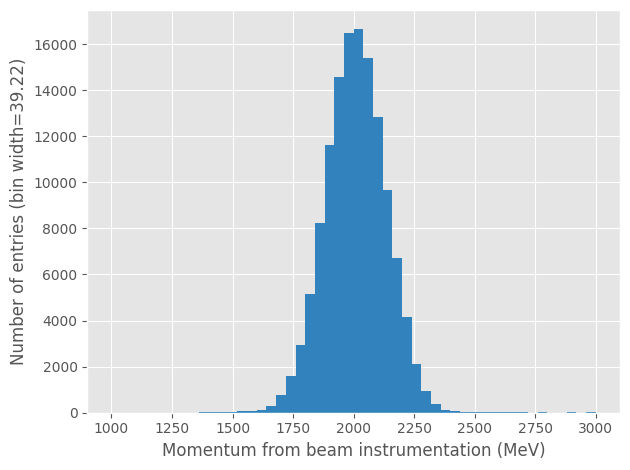

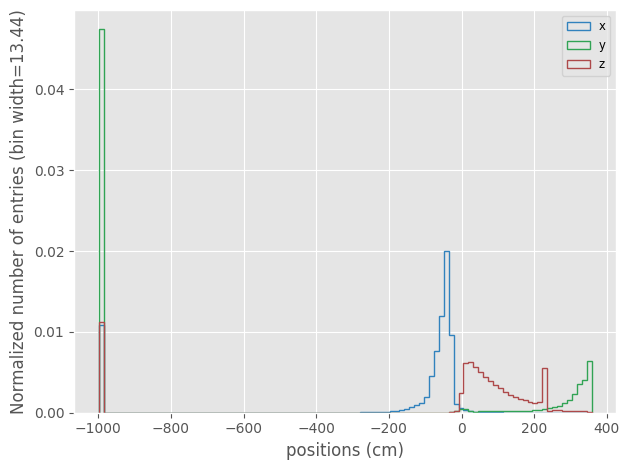

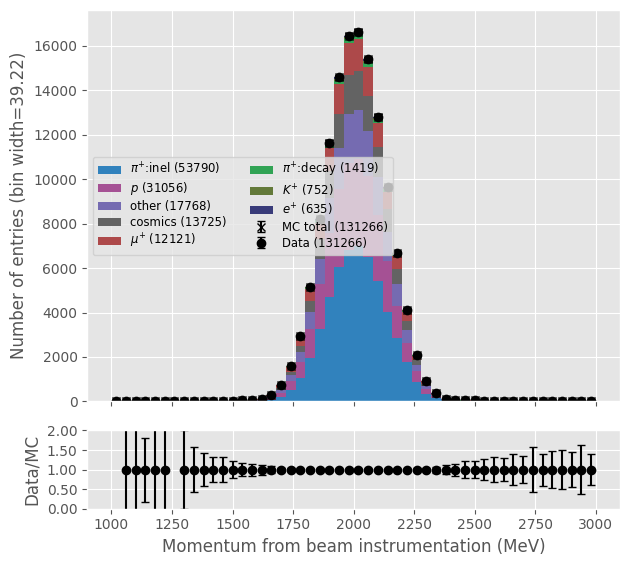

In [6]:
# there is also a custom plotting library with options to save plots into pdf documents

# PlotBook class saves any generated pdfs to a single document. This is an example using context managers. (set to true to save the plots, otherwise they are displayed in the notebook.)
with Plots.PlotBook("example_notebook_plots", False) as book:
    Plots.PlotHist(mc.recoParticles.beam_inst_P, bins = 50, xlabel = "Momentum from beam instrumentation (MeV)", range = [1000, 3000]) # a function wrapper for plt.hist

    Plots.PlotHistComparison([
        mc.recoParticles.beam_endPos_SCE.x,
        mc.recoParticles.beam_endPos_SCE.y,
        mc.recoParticles.beam_endPos_SCE.z
        ], labels = ["x", "y", "z"], xlabel = "positions (cm)") # make a comparison plot between multiple histograms (note the labels are required)

    Plots.PlotTagged(
        mc.recoParticles.beam_inst_P, # MC to plot
        Tags.GenerateTrueBeamParticleTags(mc), # The tag the true particle has.
        data2 = mc.recoParticles.beam_inst_P, # Data to plot
        bins = 50,
        x_label = "Momentum from beam instrumentation (MeV)",
        x_range = [1000, 3000]
        ) # more advancde plot for MC (and Data optionally), that allows for tagging samples in the data (good when visualising data that contains multiple unit sample types)

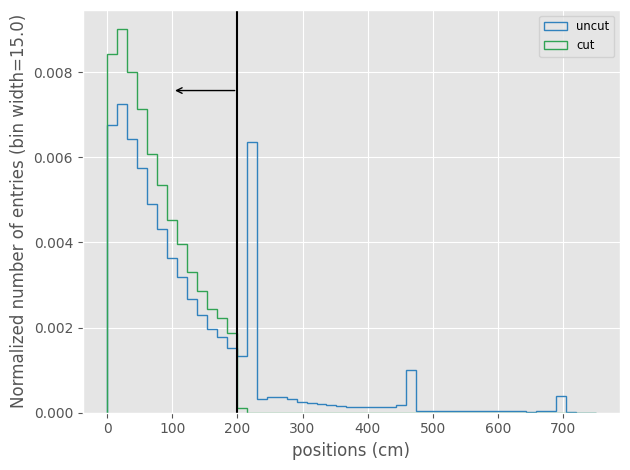

In [7]:
# Note that you can perform boolean logic on arrrays. this is used to select data based on some criteria

cut = 200 # cm
mask = mc.recoParticles.beam_endPos_SCE.z < cut # the end z position of the beam particle (where it stops in the TPC) must be less than "cut"

Plots.PlotHistComparison([
    mc.recoParticles.beam_endPos_SCE.z,
    mc.recoParticles.beam_endPos_SCE.z[mask]
    ],
    bins = 49,
    x_range = [0, 750],
    labels = ["uncut", "cut"],
    xlabel = "positions (cm)",
    histtype = "step") # make a comparison plot between multiple histograms (note the labels are required)

Plots.DrawCutPosition(cut, arrow_loc = 0.8, arrow_length = 100, face = "left")

In [10]:
from apps.cex_analysis_input import BeamPionSelection, args_to_dict


config = "/home/pemb6649/pi0-analysis/analysis/work/analysis_demo/analysis_config.json"
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration(config))
args_c = args_to_dict(args)

selected_events = BeamPionSelection(mc, args_c, True)
print(ak.count(selected_events.eventNum))


'BeamPionSelection' executed in 0.0283s

31476

In [13]:
num_events = len(selected_events.recoParticles.track_chi2_proton)
num_events

31476

In [14]:
pions = 0
for event in range(num_events):
    for track in range(len(selected_events.recoParticles.track_chi2_proton[event])):
        particle_pdg = selected_events.trueParticlesBT.pdg[event][track]
        if particle_pdg == 211 or particle_pdg == -211:
            pions += 1
print(f"Number of pions: {pions}")

Number of pions: 30410